<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Alexander Nichiporenko, AlexNich
    
## <center> Tutorial
### <center> "Anomaly Detection: Isolation Forest"

<center>
<img src="../../img/out_liar.jpg" />

# Introduction.

In our course we quite a bit touched unsupervised learning tasks (reduction of dimenstion and clustering), and one more important class remained unnoticed - the detection of anomalies.

In data science anomaly detection (outlier or novelty detection) is the identification of rare items, events or observations which raise suspicions by differing significantly from the majority of the data. Typically the anomalous items will translate to some kind of problem such as bank fraud, a structural defect, medical problems or errors in a text. Anomalies are also referred to as outliers, novelties, noise, deviations and exceptions. Outliers often reduce the quality of ML algorithms because models tune to them.

# A bit of theory and the main idea of algorithm.

One of the proven anomaly detection algorithms is the Isolation Forest. As the name implies - this is an ensemble of trees, which are built independently of each other. But in this case, the principle of building a tree is different from what is used in regression or classification problems - minimizing the splitting criterion at each step.
The trees are also binary, but at each node the feature is chosen randomly, the feature values for splitting are also chosen randomly from the range (min, max) that the feature accepts. The tree is built to the maximum possible depth - when there is only one object in each leaf.
With this approach, it appears that the anomalies will get to the final leaf much earlier than normal objects. This is the principle of detecting anomalies which Isolation Forest uses, this algorithm "isolates" anomalies  by normal objects at early steps.

Perhaps it seems not quite obvious, but we can consider the following one-dimensional toy example - such a set of numbers  [1,20,21,25]. Obviously, the outlier in this case is the number 1. If we choose the threshold for the first splitting (1,25), then in the overwhelming majority of cases, the number 1 will immediately “isolate” in the first leaf of the tree. Let's simulate this situation for 1000 random threshold choices.

In [1]:
#Importing libaries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Toy example

hits=0
K=1000
for k in range(K):
    np.random.seed(k+101)
    split=np.random.uniform(1,25)
    if split<20:
        hits+=1
        
print ('The portion of cases when the "1" goes to the first leaf:', hits/K)

The portion of cases when the "1" goes to the first leaf: 0.804


In this way, we can measure the anomaly score using the path length of the object, i.e. the number of edges an observation must pass in the tree going from the root to the terminal node. But we have a problem, for sample data $X$= {$x_1,...,x_n$} the maximum possible height of isolation tree grows in the order of $n$, the average path length grows in the order of $log({n})$. Therefore, we cannot compare the anomaly of objects in samples of different sizes, normalization by any of the above values will not help either. So we will use this formula for normalization:

## $$c{(n)} = 2H(n-1) - {2 (n-1)\over n}$$

where $H(n-1)$ is $n$-$Harmonic$ number:

## $$H(n-1) = \sum_{k=1}^{n-1} {1\over k} \approx \gamma\ {(Euler's\ constant)} + \ln{(n-1)} \approx 0.5772156649 + \ln{(n-1)}$$

$c({n})$ gives the average path length of unsuccessful search in Binary Search Tree (BST). We can use it because isolation tree has a equivalent structure to BST and $c({n})$ equals to estimation of average $h({x})$ for external nodes.

So final anomaly score is calculated by this formula:

##  $$S(x,n) = {2 ^ {E(x)\over c(n)}}$$
where $E(x)$ - average path length in trees of our forest where example $x$ was isolated:

##  $$E(x) = {1\over N}\sum_{i=1}^{N} {h(x)_i}$$
and $N$ - number of trees in the forest.

$S(x,n)$ changes from $0$ to $1$. When $S(x,n)$ of example is very close to $1$ it means that it is definitely anomaly, when it much smaller then $0.5$ then this example safe to be regarded as normal instance, and if all examples have $S(x,n) \approx 0.5$, then the entire data doesn't have any distinct anomaly.

When we decide which example is anomaly we can choose portion of examples with high score or make a threshold in $S(x,n)$.

# Let's grow our IsolationForest!

In this part of the tutorial, we will implement our own Isolation Forest and see how it works with outliers and normal objects.

In [3]:
#Importing libaries ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import log as ln

In [4]:
#External Node - leaf with 1 example

class ExNode:
    def __init__(self,size):
        self.size=size

In [5]:
#Internal Node

class InNode:
    def __init__(self,left,right,split_feature,split_threshold):
        self.left=left
        self.right=right
        self.split_feature=split_feature
        self.split_threshold=split_threshold

In [6]:
#Build one Isolation tree

def IsolationTree(X):
    if len(X)<=1:
        return ExNode(len(X))
    else:
        f=np.random.choice(X.columns)
        t=np.random.uniform(X[f].min(),X[f].max())
        X_l=X[X[f]<t]
        X_r=X[X[f]>=t]
        return InNode(IsolationTree(X_l),IsolationTree(X_r),f,t)

In [7]:
#Build forest

def MyIsolationForest(X,n_trees):
    forest=[]
    for i in range(n_trees):
        forest.append(IsolationTree(X))
    return forest

In [8]:
#Depth of external node where object was isolated

def path_length(x,tree,curr_depth):
    if isinstance(tree,ExNode):
        return curr_depth
    t=tree.split_feature
    if x[t]<tree.split_threshold:
        return path_length(x,tree.left,curr_depth+1)
    else:
        return path_length(x,tree.right,curr_depth+1)

Functions which is needed to calculate degree of anomaly: $E(d), H(x), c(n), S(x,n)$.

In [9]:
def E(d):
    return np.mean(d)

def H(x):
    return ln(x) + 0.5772156649

def c(n):
    return 2 * H(n-1) - 2 * (n-1)/n if n>2 else 1 if n ==1 else 0

def S(x,n):
    return 2 ** (-E(x)/c(n))

## Let's find outliers using our forest!

Firstly we will generate 1-d data - normal distribution and find average path length and $S(x,n)$ of normal and anomaly objects depends on number of trees.

In [10]:
# Generating normal distributed 1d-data
random_generator = np.random.RandomState(42)

true_mean=100
true_sigma=10

X_all = random_generator.normal(true_mean, true_sigma, size=500)

print ('Normal interval:',true_mean - 2 * true_sigma,'-', true_mean + 2 * true_sigma)

X_outliers = pd.DataFrame(np.hstack([X_all[X_all<true_mean-2*true_sigma],X_all[X_all>true_mean+2*true_sigma]]),columns=['x'])
X_normal = pd.DataFrame(list(set(X_all).difference(set(X_outliers))),columns=['x'])
X_all = pd.DataFrame(X_all, columns=['x'])

print ('Partition of outliers:', len(X_outliers)/len(X_all))

Normal interval: 80 - 120
Partition of outliers: 0.04


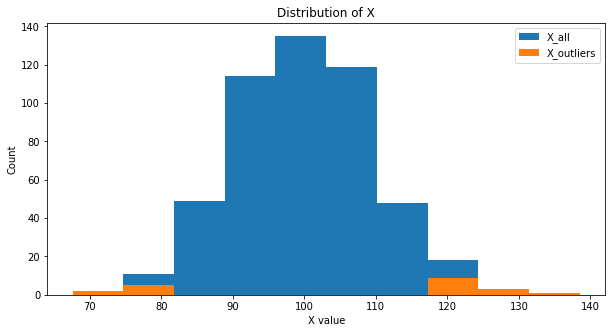

In [11]:
plt.figure(figsize=(10,5))
plt.hist(X_all['x'],bins=10);
plt.hist(X_outliers['x'],bins=10);
plt.legend(['X_all','X_outliers']);
plt.ylabel('Count');
plt.xlabel('X value');
plt.title('Distribution of X');

In [12]:
#Outlier for test

X_outliers.iloc[2,:]

x    67.587327
Name: 2, dtype: float64

In [13]:
#Normal example for test

X_normal.iloc[0,:]

x    108.657552
Name: 0, dtype: float64

In [14]:
%%time

anomaly_x=[]
normal_x=[]

anomaly_mean_depth=[]
normal_mean_depth=[]

anomaly_S=[]
normal_S=[]

for n in range(1,51,1):
    MyIF=MyIsolationForest(X_all,n)
    for iTree in MyIF:
        anomaly_x.append(path_length(X_outliers.iloc[2,:],iTree,0))
        normal_x.append(path_length(X_normal.iloc[0,:],iTree,0))
    anomaly_mean_depth.append(E(anomaly_x))
    normal_mean_depth.append(E(normal_x))
    anomaly_S.append(S(anomaly_x,len(X_all)))
    normal_S.append(S(normal_x,len(X_all)))

Wall time: 8min 29s


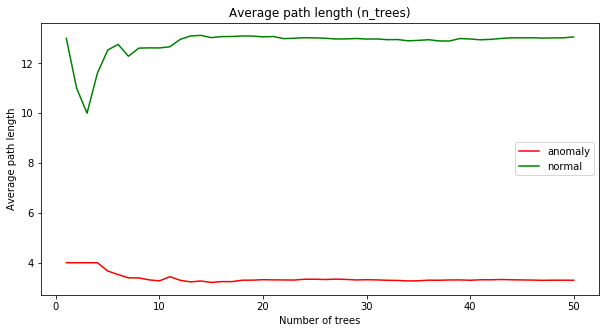

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(1,51,1),anomaly_mean_depth,c='r');
plt.plot(range(1,51,1),normal_mean_depth,c='g');
plt.title('Average path length (n_trees)');
plt.legend(['anomaly','normal']);
plt.xlabel('Number of trees');
plt.ylabel('Average path length');

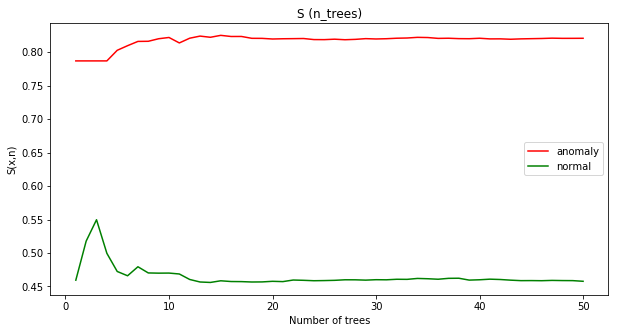

In [16]:
plt.figure(figsize=(10,5))
plt.plot(range(1,51,1),anomaly_S,c='r');
plt.plot(range(1,51,1),normal_S,c='g');
plt.title('S (n_trees)');
plt.legend(['anomaly','normal']);
plt.xlabel('Number of trees');
plt.ylabel('S(x,n)');

As we can see anomaly object has obviously less path depth and bigger $S(x,n)$. Also we don't need many trees to detect anomalies, approximately at 15 trees we reach the asymptote.

Ok, let's find outliers in 2-d data. We will use IsolationForest with 30 trees to find our otliers and check the quality of detection.

In [17]:
# Generating 2d-data
random_generator = np.random.RandomState(42)

# Generating normal data 
X_normal = random_generator.randn(2000, 2) * 0.5
X_normal = pd.DataFrame(X_normal, columns = ['x1', 'x2'])
X_normal['type']='normal'

# Generating outliers
X_outliers_1 = random_generator.uniform(low=-6, high=6, size=(78, 2))
X_outliers_2 = random_generator.uniform(low=-6, high=-3, size=(35, 2))

X_outliers=np.vstack([X_outliers_1,X_outliers_2])

X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])
X_outliers['R']=X_outliers['R']=np.sqrt(X_outliers['x1'] ** 2 + X_outliers['x2'] ** 2)
X_outliers=X_outliers[X_outliers['R']>3].drop(columns=['R'])
X_outliers['type']='anomaly'

# Full data

X_full=pd.concat([X_normal,X_outliers])

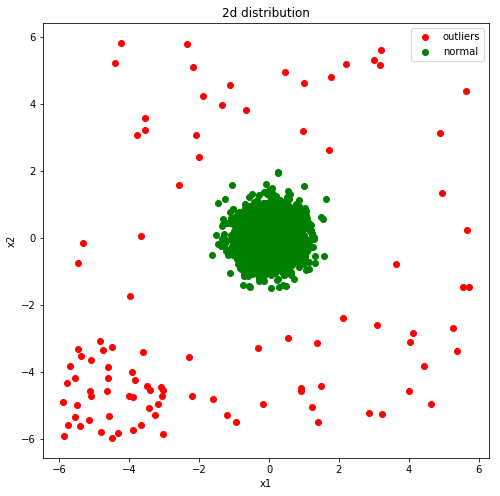

In [18]:
plt.figure(figsize=(8,8))
plt.scatter(X_outliers['x1'],X_outliers['x2'],c='r');
plt.scatter(X_normal['x1'],X_normal['x2'],c='g');
plt.xlabel('x1');
plt.ylabel('x2');
plt.legend(['outliers','normal']);
plt.title('2d distribution');

In [19]:
X_normal.shape,X_outliers.shape, X_full.shape

((2000, 3), (100, 3), (2100, 3))

In [20]:
%%time
MyIF=MyIsolationForest(X_full[['x1','x2']],30)

Wall time: 48.6 s


In [21]:
X_outliers.iloc[0,:]

x1     -0.179784
x2      -4.97516
type     anomaly
Name: 0, dtype: object

In [22]:
X_normal.iloc[0,:]

x1       0.248357
x2     -0.0691322
type       normal
Name: 0, dtype: object

In [23]:
%%time

aScore=[]


for i in range(X_full.shape[0]):
    depth=[]
    for iTree in MyIF:
        depth.append(path_length(X_full.iloc[i,:],iTree,0))
        
    aScore.append(S(depth,X_full.shape[0]))

Wall time: 18.1 s


In [24]:
X_full['aScore']=aScore

In [25]:
t = X_full['aScore'].quantile(0.95)
X_full['Outlier']=X_full['aScore'].apply(lambda x: -1 if x >=t else 1) #-1 for outliers and 1 for normal object

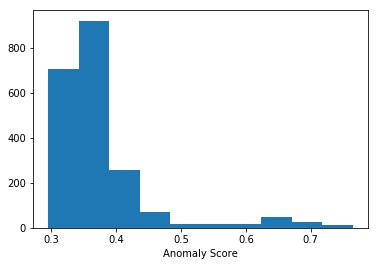

In [26]:
plt.hist(X_full['aScore']);
plt.xlabel('Anomaly Score');

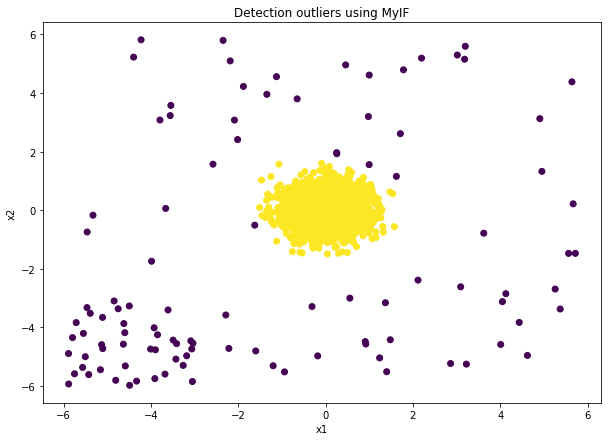

In [27]:
plt.figure(figsize=(10,7))
plt.scatter(X_full['x1'],X_full['x2'],c=X_full['Outlier']);
plt.title('Detection outliers using MyIF');
plt.xlabel('x1');
plt.ylabel('x2');

Reader may notice that our forest works long enough. What will happen to the larger dataset? But fortunately, during the experiments, the authors of this algorithm found that not all data should be used to build a single tree from a forest, which leads not only to an increase in the speed of work, but also improves the quality of anomalies detection. This is because subsamples have fewer normal points ‘interfering’ with anomalies, thus, making anomalies easier to isolate. It is shown on the image below.

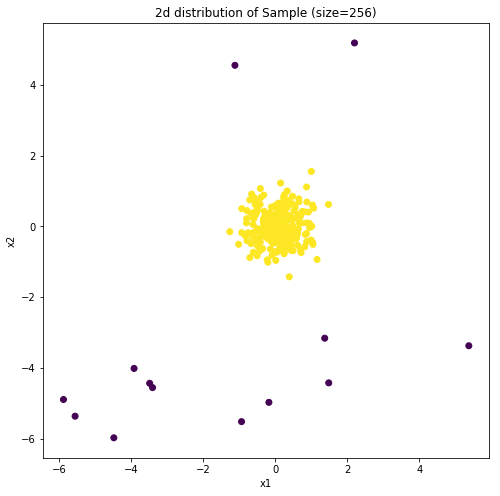

In [28]:
X_sample = X_full.sample(256)
plt.figure(figsize=(8,8))
plt.scatter(X_sample['x1'],X_sample['x2'],c=X_sample['type'].map({'normal':1,'anomaly':-1}));
plt.xlabel('x1');
plt.ylabel('x2');
plt.title('2d distribution of Sample (size=256)');

We won't develop our IsolationForest and will use sklearn's version with these improvements further.

# Sklearn is our everything!

In [29]:
#Import IsolationForest

from sklearn.ensemble import IsolationForest

#### IsolationForest important params:

    n_estimators -  The number of base estimators in the ensemble, default=100.
    max_sample - The number of samples from data to train each tree in the forest, default "auto" = min(256, n_samples)
    max_features - The number of features from data to train each tree in the forest, default = 1.0 (all features)
    bootstrap - bootstrap, default=False
    contamination - The proportion of outliers in the data set, threshold, default = 0.1


We will test this implementation of IF on our 2-d dataset.

In [30]:
isof = IsolationForest(random_state=77,n_jobs=4,contamination=0.05)

In [31]:
%%time
isof.fit(X_full[['x1','x2']])

Wall time: 1.8 s


IsolationForest(bootstrap=False, contamination=0.05, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=4, random_state=77,
        verbose=0)

Very fast! How about the quality?

In [32]:
# predictions
y_pred_full = isof.predict(X_full[['x1','x2']])

In [33]:
X_full['Outlier_sk']=y_pred_full

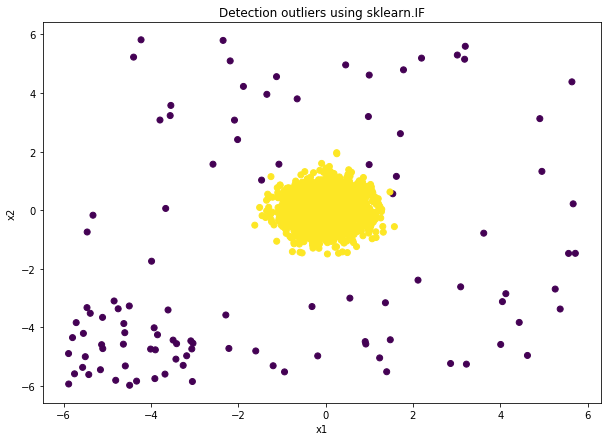

In [34]:
plt.figure(figsize=(10,7))
plt.scatter(X_full['x1'],X_full['x2'],c=X_full['Outlier_sk']);
plt.title('Detection outliers using sklearn.IF');
plt.xlabel('x1');
plt.ylabel('x2');

Image looks grate! Purple points are outliers which IsolationForest found. 

In [35]:
#count of detected outliers "-1"
X_full.iloc[2000:,4].value_counts()

-1    100
Name: Outlier, dtype: int64

As we can see our IsolationForest found almost of outliers.

# Time to challenge!

It this part of tutorial we will compare IsolationForest with another algorithms. We will use this data set from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
pd.options.display.max_columns=500

In [37]:
data = pd.read_csv('creditcard.csv')

Let's look at the data. All features are numeric, so we will not do any data processing and will train models on what we downloaded. To prevent overfitting of supervised models we will devide initial dataset by train and test parts.

In [38]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [39]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [68]:
X = data.drop(columns=['Class'])
y = data['Class']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [70]:
#Look at portion of fraud transactions
y.mean(),y_train.mean(), y_test.mean(), len(y[y==1]), len(y), len(y_test), len(y_test[y_test==1])

(0.001727485630620034,
 0.0017355189502618327,
 0.0017087415001814075,
 492,
 284807,
 85443,
 146)

Whoah! Fraud transactions is about 0.2% of all transactions!
We will use all algorithms "from the box" without tuning parameters. We need to find fraud transcations quickly and as much as possible.

In [71]:
#supervised
rf = RandomForestClassifier(random_state=42,n_jobs=4)
lr = LogisticRegression(random_state=42)
xg = XGBClassifier(random_state=42,n_jobs=4)
#unsupervised
IF = IsolationForest(random_state=42,n_jobs=4,contamination=0.01,n_estimators=300)
LOF = LocalOutlierFactor(contamination=0.01,n_jobs=4)

In [72]:
%%time
rf.fit(X_train,y_train)

Wall time: 5.21 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [73]:
%%time
lr.fit(X_train,y_train)

Wall time: 3.15 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
%%time
xg.fit(X_train,y_train)

Wall time: 14.1 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [75]:
%%time
IF.fit(X_train,y_train)

Wall time: 42.2 s


IsolationForest(bootstrap=False, contamination=0.01, max_features=1.0,
        max_samples='auto', n_estimators=300, n_jobs=4, random_state=42,
        verbose=0)

In [76]:
%%time
LOF.fit(X_train,y_train)

Wall time: 4.87 s


LocalOutlierFactor(algorithm='auto', contamination=0.01, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=4, n_neighbors=20,
          p=2)

In [77]:
rf_pred = rf.predict_proba(X_test)[:,1]
lr_pred = lr.predict_proba(X_test)[:,1]
xg_pred = xg.predict_proba(X_test)[:,1]
IF_pred = IF.predict(X_test)
LOF_pred = LOF.fit_predict(X_test)

In [78]:
X_test['true']=y_test
X_test['IF_pred']=IF_pred
X_test['LOF_pred']=LOF_pred
X_test['xg_pred']=xg_pred
X_test['rf_pred']=rf_pred
X_test['lr_pred']=lr_pred

C:\Users\vnich\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\vnich\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\vnich\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Let's check how many fraud transactions found each algorithm:

In [84]:
X_test[X_test['IF_pred']==-1]['true'].value_counts()

0    719
1     77
Name: true, dtype: int64

In [85]:
X_test[X_test['LOF_pred']==-1]['true'].value_counts()

0    843
1     12
Name: true, dtype: int64

In [86]:
X_test.sort_values(by='rf_pred',ascending=False)['true'].head(855).value_counts()

0    727
1    128
Name: true, dtype: int64

In [87]:
X_test.sort_values(by='lr_pred',ascending=False)['true'].head(855).value_counts()

0    738
1    117
Name: true, dtype: int64

In [88]:
X_test.sort_values(by='xg_pred',ascending=False)['true'].head(855).value_counts()

0    726
1    129
Name: true, dtype: int64

As we can see Isolation Forest solved this problem worse than supervised algorithms, but on the whole it is very good for the random. And compared to the LOF, the result is much better. And in this case we don't need to know what transactions are fraud - make a train dataset with target variable.

# Conclusion

In the conclusion ot the tutorial I want to summarise everything about Isolation Forest. This algorithm has very simple idea of anomaly detection: it isolates anomalies rather than normal observations. Also Isolation Forest converges quickly with a small ensemble size, which enables it to detect anomalies with high efficiency.

If you want to learn more about Isolation Forest, I recommend reading the article from the authors of the algorithm:

http://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf

https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf
